In [19]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy
import iris
from iris.experimental.equalise_cubes import equalise_attributes
import matplotlib.pyplot as plt

import os, sys
cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv
import spatial_weights
import timeseries
import general_io as gio

In [20]:
%matplotlib inline

## Global mean sea water salinity

In [53]:
def plot_soga(model, infer_wfo=False):
    """Plot global mean sea water salinity control data"""
    
    file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/soga/latest/soga_*.nc' %(model)
    soga_files = glob.glob(file_pattern)
    
    soga_cube, history = gio.combine_files(soga_files, 'sea_water_salinity')
    soga_cube = gio.salinity_unit_check(soga_cube)
    
    soga_cube = timeseries.convert_to_annual(soga_cube)
    
    if not inferred_wfo:
        plt.plot(soga_cube.data)
        plt.ylabel('salinity (g/kg)')
        plt.title(soga_cube.long_name + ', ' + model)
        plt.ticklabel_format(useOffset=False, style='plain')
    else:
        s_orig = numpy.ones(soga_cube.data.shape[0]) * soga_cube.data[0]
        wfo = numpy.fromiter(map(inferred_wfo, s_orig, soga_cube.data), float)
        plt.plot(wfo)
        plt.ylabel('kg')
        plt.suptitle("Inferred cumulative net water flux into ocean" + ', ' + model)
        
    plt.xlabel('timestep')
    plt.show()

## Water flux into sea water

This variable represents the net freshwater flux at the ocean surface. In other words, it is the sum of the rainfall flux, snowfall flux, evaporation flux, river runoff and water flux from icebergs.

It's worth noting how freshwater fluxes are represented differently across models, with some models converting the freshwater flux to a virtual salt flux (so that the volume of the ocean stays the same). [This paper](https://www.sciencedirect.com/science/article/pii/S2095927317300932) gives a good overview.

[In the CNRM-CM5 model wfo variable is positive upwards](http://www.umr-cnrm.fr/cmip5/spip.php?article24). I wonder if that's the case for other models? (TODO: Look at spatial fields to determine this.)

In [22]:
def plot_wfo(model, cumsum=True):
    """Plot water flux into sea water data
    
    The units need to be converted from kg m-2 s-1 to kg in order
    to be able to work effectively with the salinity data (which is g/kg)
    
    """
    
    wfo_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/wfo/latest/wfo_*.nc' %(model)
    wfo_files = glob.glob(wfo_pattern)
    
    wfo_cube, history = gio.combine_files(wfo_files, 'water_flux_into_sea_water')
    wfo_cube = timeseries.convert_to_annual(wfo_cube)
    
    area_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/fx/ocean/r0i0p0/areacello/latest/areacello_*.nc' %(model)
    area_file = glob.glob(area_pattern)
    
    area_cube = iris.load_cube(area_file)
    area_array = uconv.broadcast_array(area_cube.data, [1, area_cube.ndim], wfo_cube.shape)
    
    units = str(wfo_cube.units)
    assert units == 'kg m-2 s-1'
    wfo_cube.units = units.replace('m-2', '')
    wfo_cube.data = wfo_cube.data * area_array

    # Calculate the global sum
    wfo_cube = wfo_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=area_array)
    wfo_cube.remove_coord('latitude')
    wfo_cube.remove_coord('longitude')

    # Remove the s-1
    assert 'days' in str(wfo_cube.coord('time').units)
    time_span_days = wfo_cube.coord('time').bounds[:, 1] - wfo_cube.coord('time').bounds[:, 0]
    time_span_seconds = time_span_days * 60 * 60 * 24
    wfo_cube.data = wfo_cube.data * time_span_seconds
    units = str(wfo_cube.units)
    wfo_cube.units = units.replace('s-1', '')
    
    if cumsum:
        plt.plot(numpy.cumsum(wfo_cube.data))
        plt.title("Cumulative net water flux into the ocean")
    else:
        plt.plot(wfo_cube.data)
        plt.title("Annual net water flux into the ocean")

    plt.xlabel('year')
    plt.ylabel(wfo_cube.units)
    plt.show()

## Relationships

How are soga ($S$) and cumulative global total wfo ($\Delta M$) related?

$\Delta M = -M_{globe}(1 - \frac{S_{orig}}{S_{new}})$

where $M_{globe}$ is the mass of the global ocean. 

(This assumes that the total ocean salt content is constant in the CMIP5 models.)

In [23]:
def inferred_wfo(s_orig, s_new):
    """Calculate the inferred cumulative global total wfo for a given change in soga.
    
    wfo = net water flux into sea water
    soga = global mean sea water salinity
    
    """
    
    v = 1.35e18  # m3; volume of global ocean - could calculate from volcello data
    p = 1027  # kg/m3; average density of global ocean - could calculate from rhopoto data
    m_globe = v * p
    
    delta_m = -1 * m_globe * (1 - (s_orig / s_new))    
    
    return delta_m

In [24]:
print(inferred_wfo(30, 30), 'kg')

-0.0 kg


In [25]:
print(inferred_wfo(30, 31), 'kg')

-4.472419354838706e+19 kg


In [26]:
print(inferred_wfo(30, 29), 'kg')

4.780862068965527e+19 kg


Sanity check:

In [27]:
v = 1.35e18  # m3; volume of global ocean - could calculate from volcello data
p = 1027  # kg/m3
m_globe = v * p

In [28]:
(0.03 * m_globe) / (m_globe + 4.780862068965527e+19)

0.028999999999999998

In [29]:
(0.03 * m_globe) / (m_globe -4.472419354838706e+19)

0.031

So to compare the wfo and soga data I could plot the wfo timeseries against an inferred wfo timeseries constructed from soga data.

## Results

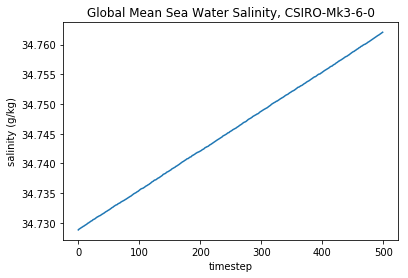

In [30]:
plot_soga('CSIRO-Mk3-6-0')

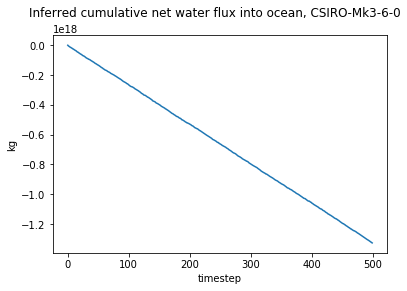

In [54]:
plot_soga('CSIRO-Mk3-6-0', infer_wfo=True)

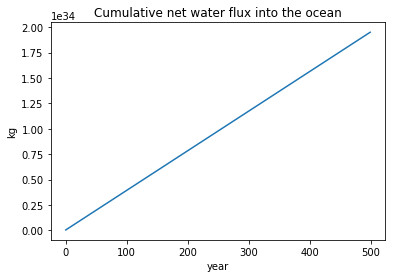

In [87]:
plot_wfo('CSIRO-Mk3-6-0')

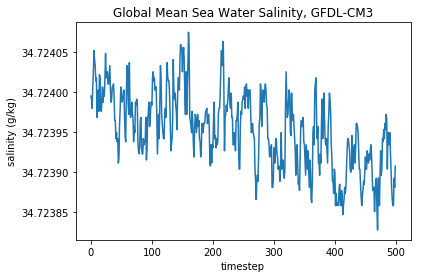

In [111]:
plot_soga('GFDL-CM3')

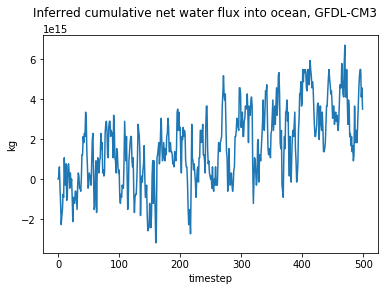

In [55]:
plot_soga('GFDL-CM3', infer_wfo=True)

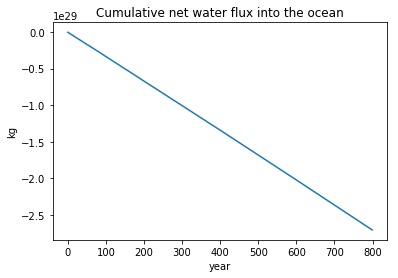

In [107]:
plot_wfo('GFDL-CM3')

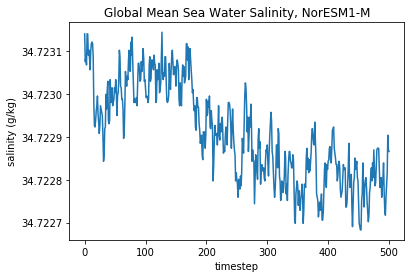

In [110]:
plot_soga('NorESM1-M')

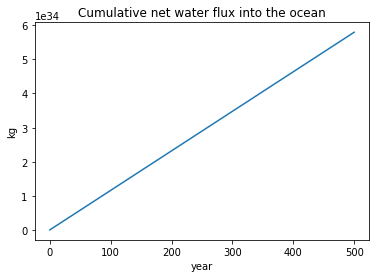

In [112]:
plot_wfo('NorESM1-M')

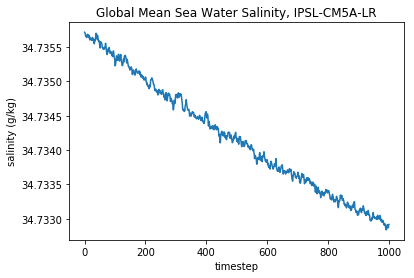

In [113]:
plot_soga('IPSL-CM5A-LR')

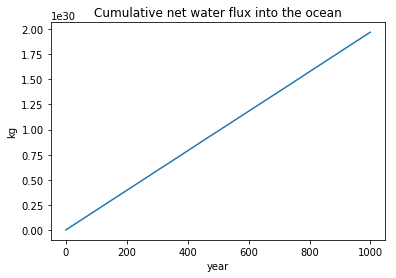

In [114]:
plot_wfo('IPSL-CM5A-LR')

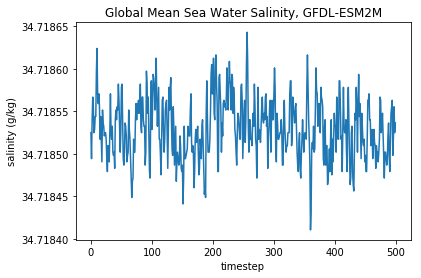

In [115]:
plot_soga('GFDL-ESM2M')

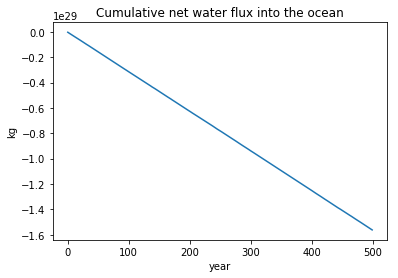

In [116]:
plot_wfo('GFDL-ESM2M')